<h2> Network Projection with 5 different methods </h2>

<h3> 1. Introduction </h3>

<p> Network Projection is a common case in social sciences. Not every method is right for every kind of dataset therefore they should be tested before just doing the bipartite projection. Many methods give back a full weighted graph which has to be be filtereed and this task not obvious either. I this Notebook project I am going to compare 5 different bipartite network projection methods, which are the following ones: </p>

* Simple Projection
* Jaccard Similarity
* Cosine Similarity
* Pearson Similarity
* Newman Projection 
* Hypergeometric weighting

<p>In order to get comaprable results I used the same dataset at each case, the Marvel Hero-Issue Bipartite network(see in files). The report follows the following structure; first I sumamrize each methods mathematical background in a nutshell, then have a look at on the projected weight distributions, then filter all the networks with the same so-called Disparity-filtering, where alpha is given by the Bonferroni correction adn finally understanding and analyzing the results. </p>

<b> Reading the files and creating the bipartite network </b>

In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import scipy as sp
import numpy as np
import math
import cmath
import csv
import itertools
import sys
import unicodedata
import string
from scipy.stats import hypergeom
from math import log
from scipy import special
from numpy import mean, sqrt, square
from collections import defaultdict, Counter
from itertools import permutations
from matplotlib.dates import date2num , DateFormatter
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from IPython.display import Image

import igraph

%matplotlib inline

In [2]:
g=nx.Graph()
heroes_ids= set()
for line in open ('marvel_heroes.nodes'):
    id, name = line.strip().split(' ', 1)
    g.add_node(int(id), {'name': name.replace('"', ''), 'bpartite': 0})
    heroes_ids.add(int(id))

In [61]:
with open('marvel_hero_attr.csv','wb') as csvfile:
    writer=csv.writer(csvfile)
    for (a,k) in g.nodes(data=True):
        writer.writerow((str(a), unicode(k['name'])))

In [3]:
issues_ids= set()
issue_name_to_id={}
for line in open ('marvel_issues.nodes'):
    id, name = line.strip().split(' ', 1)
    g.add_node(int(id), {'name': name.replace('"', ''), 'bpartite': 1})
    issues_ids.add(int(id))
    issue_name_to_id[name.replace('"', '')]=int(id)

In [4]:
for line in open ('marvel.edges'):
    ids = map (int, line.strip().split())
    from_id = ids[0]
    for to_id in ids[1:]:
        g.add_edge(from_id, to_id)    

In [5]:
Projection_structure=defaultdict(set)
issues=()

for (hero, issue) in g.edges():
    Projection_structure[hero].add(issue)

In [7]:
def transpose(out_edges):
    in_edges = {}
    for src, es in out_edges.items():
        for dst in es:
            in_edges.setdefault(dst, set()).add(src)

    return in_edges

In [8]:
in_edges=dict(Projection_structure)
out_edges=dict(transpose(Projection_structure))

<h3> 2. Projection methods and their background </h3>

<h4> 2.1. Simple Projection </h4>

<p> In the projected network edges are weighted by the number of times the common association is repeated. [1] <p> 

In [63]:
def simple_projection(out_edges):
    res = {}
    
    for s in out_edges.values():
        # s will be a set of neighbors of a given node
        for src in s:
            es = res.setdefault(src, {})
            for dst in s:
                if src == dst:
                    continue
                
                weight = es.get(dst, 0)
                es[dst] = weight + 1
    return res

<h4> 2.2. Jaccard Similarity </h4>

<p> The Jaccard coefficient is defined by the size of the intersection divided by the size of the union of two finite sets. [2]
</p> 



$$ Jaccard  Similarity (A, B) = {|A \cap B| \over |A \cup B|}
$$


In [69]:
def jaccard_similarity(out_edges, in_edges):
    res = simple_projection(out_edges)
    
    for src, es in res.items():
        for dst, w in es.items():
            d_src = float(len(in_edges[src]))
            d_dst = float(len(in_edges[dst]))
            es[dst] = w / (d_src + d_dst - w)
    
    return res


<h4>2.3. Cosine Similarity</h4>

<p> It measures the similarity between two vectors while computing the cosine of the angle between them. The cosine of 0° is 1, and it is less than 1 for any other angle. Two vectors with the same orientation have a cosine similarity of 1, two vectors at 90° have a similarity of 0, and two vectors diametrically opposed or independent have a similarity of -1.It is highly regarded to use in positive space where the outcome is bounded in [0,1]. [3]</p>

In [64]:
def cosine_similarity(out_edges, in_edges):
    res = simple_projection(out_edges)
    
    for src, es in res.items():
        for dst, w in es.items():
            d_src = len(in_edges[src])
            d_dst = len(in_edges[dst])
            es[dst] = w / (d_src * d_dst) ** .5
    
    return res

<h4>2.4. Pearson Similarity</h4>

<p>In this case, similarity between two nodes is measured by computing the Pearson R correlation between them. [4]</p>



In [65]:
def pearson_coefficient(out_edges, in_edges):
    res = simple_projection(out_edges)
    n = float(len(out_edges))
    
    for src, es in res.items():
        for dst, w in es.items():
            p_src = len(in_edges[src]) / n
            p_dst = len(in_edges[dst]) / n
            var = p_src * p_dst * (1. - p_src) * (1. - p_dst)
            es[dst] = (w / n - p_src * p_dst) / var ** .5
    
    return res

<h4>2.5. Newman Projection</h4>

Newman (2001) proposed when he was analysing scheintific collaboration that the number of the collaboraters should be taken into account by defining the weights among them using the following formula: Wij= sum(1/Np - 1) where Np is the number of authors on paper p. 
In the context of scientific collaboration networks, it means that if two scientists only wrote a single paper together with no other co-authors get a weight of 1. If two scientists have written two papers together without any co-author, the weight of their tie would be 2 and so on. This method finally takes care about the different set sizes. [5]</p>

In [9]:
def newman_projection(out_edges):
    res = {}
    
    for s in out_edges.values():
        for src in s:
            es = res.setdefault(src, {})
            d = len(s)
            
            for dst in s:
                if src == dst:
                    continue
                
                # Basically the same as a simple projection, except that
                # if a node is connected to multiple other nodes, the additional
                # weight is penalized.
                es[dst] = es.get(dst, 0) + 1. / (d - 1.)
    return res

<h4>2.6. Hypergeometric Weighting</h4>

<p>The main goal of any projection method would be to measure how unusual it is to have so many common neighbors of two nodes. To answer this question properly, <b>we need to establish a null model</b> that describes the probability distribution of number of common neighbours for every pair of nodes in the network. </p>

<p>Let $V$ and $W$ be modes of a bipartite network, while $|V|$ and $|W|$ be the size of the modes (the number of the nodes in the given node) respectively. Let $v_i, v_j \in V$, $|N(v_i)| = d_i$ and $|N(v_j)| = d_j$ be the number of neighbors of these nodes in mode $W$. Let $|N(v_i) \cap N(v_j)| = d_{ij} = d_{ji}$ be the number of common neighbors of node $v_i$ and $v_j$. </p>

<p>The most simple null model would be that every node $v_i$ chooses $d_i$ neighbours in mode $W$ at random, independently of the other nodes. It is easy to realize that in this case the number of common neighbors for any pair of nodes $(v_i, v_j)$ should follow a <b>hypergeometric distribution, with $|d_i|, |d_j|$ and $|W|$ as parameters</b>. Let $F(n \mid d_i, d_j, |W|) = \mathcal{P}(\delta_{ij} \leq n)$ be the cummulative distribution function of $\delta_{ij}$ by the null modell. (Here $\delta_{ij}$ is a random variable defined by the null modell. We chose a greek letter for it to distinguish it from $d_{ij}$, which is the number of common neighbors in the realized network.) In practice $F(n \mid d_i, d_j, |W|)$ may be implemented as the result of the following summation, or by just using one of the built-in function provided by the chosen environment:

</p>


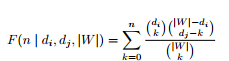

In [70]:
Image(filename='keplet.png') 

<p>
$w^*_{ij} = F(d_{ij} \mid d_i, d_j, |W|)$ would be an adequate weight for the edge, as it's value is close to $0$ if $d_{ij}$ is way lower than the expectation based on the null modell, $0.5$ if it's value is the median of the expected distribution, and $1$ if it is much higher. In most cases however we want to find a threshold value so we can fix some parameter of the network, for example the average degree. In practice these parameters may choose rapidly as the function, so we often apply the following transformation to the weights:

$$ w_{ij} = - \log \left( 1 - w^*_{ij}\right) $$


Using the transformation of the p-value as a distance metric is divisive amon scientists, some scholars accept it and some instantly reject it. Here I accept that it can be used as a similarity metric. As the results show if we keep those edges which are let's say "significantly importnant on the node-level" after the filtering we end up having more nodes and more relevant connections thenn with other methods, however it is not the most important aim in capturing the structure of the original neetwork.

</p>

In [66]:
def tbj_similarity(out_edges, in_edges):
    res = simple_projection(out_edges)
    n = len(out_edges)
    
    for src, es in res.items():
        for dst, w in es.items():
            d_src = len(in_edges[src])
            d_dst = len(in_edges[dst])
            
            # Basically negative of the log-survival function, except that
            # to avoid problems with digital precision, a maximal value is set.
            es[dst] = -log(max(1e-300, hypergeom.sf(w, n, d_src, d_dst)))
    
    return res

<b> Running the projections and creating the projected weight distributions </b>

In [10]:
simple=simple_projection(out_edges)
newman=newman_projection(out_edges)
jaccard=jaccard_similarity(out_edges, in_edges)
cosine=cosine_similarity(out_edges, in_edges)
pearson=pearson_coefficient(out_edges, in_edges)
tbj=tbj_similarity(out_edges, in_edges)

In [16]:
def weight_distr(projection):
    weights=[]
    for key,values in projection.iteritems():
        for k,i in values.iteritems():
            weights.append(i)
    
    x=max(weights)
    weights_norm=[float(i)/x for i in weights]
    
    
    plt.hist((weights_norm),bins=50)
    plt.title("Weights distribution")
    plt.ylabel("number of nodes")
    plt.xlabel("weigths")
    plt.yscale('log', nonposy='clip')
    plt.show()
    
    
    print 'Normalized weights'
    print "mean: "+ str(np.mean(weights_norm))
    print "std: "+ str(np.std(weights_norm))
    print "min: "+ str(min(weights_norm))
    print "max: "+ str(max(weights_norm))
    
    print 'Original weights'
    print "mean: "+ str(np.mean(weights))
    print "std: "+ str(np.std(weights))
    print "min: "+ str(min(weights))
    print "max: "+ str(max(weights))
    

<h3> 3. Weight Distributions </h3>

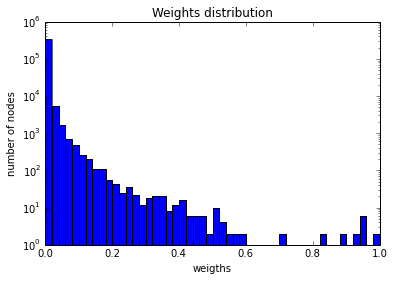

Normalized weights
mean: 0.00455121855428
std: 0.0146753791199
min: 0.00134408602151
max: 1.0
Original weights
mean: 3.38610660438
std: 10.9184820652
min: 1
max: 744


In [17]:
weight_distr(simple)

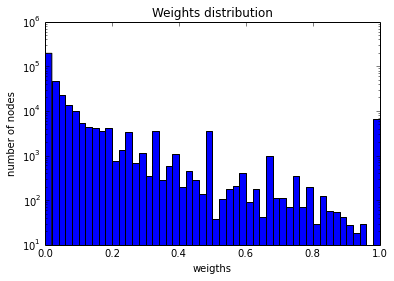

Normalized weights
mean: 0.0709844472919
std: 0.167727944976
min: 0.00057372346529
max: 1.0
Original weights
mean: 0.0709844472919
std: 0.167727944976
min: 0.00057372346529
max: 1.0


In [71]:
weight_distr(jaccard)

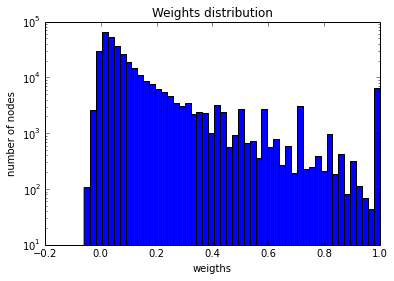

Normalized weights
mean: 0.130658496538
std: 0.197652860592
min: -0.0595602795163
max: 1.0
Original weights
mean: 0.130658496538
std: 0.197652860592
min: -0.0595602795163
max: 1.0


In [72]:
weight_distr(pearson)

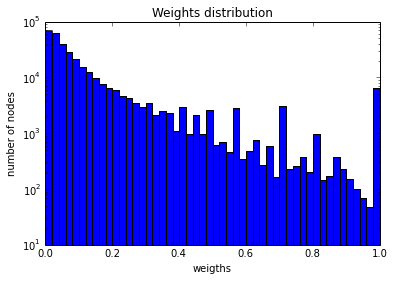

Normalized weights
mean: 0.13481002263
std: 0.195684151581
min: 0.00178140233033
max: 1.0
Original weights
mean: 0.13481002263
std: 0.195684151581
min: 0.00178140233033
max: 1.0


In [73]:
weight_distr(cosine)

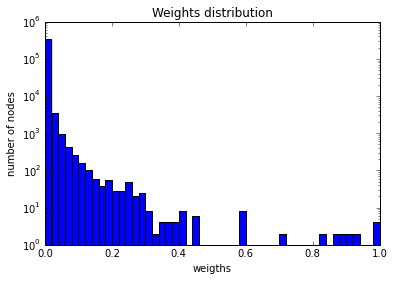

Normalized weights
mean: 0.00275145467981
std: 0.0119677062347
min: 8.85031535901e-05
max: 1.0
Original weights
mean: 0.282625232517
std: 1.2293045501
min: 0.00909090909091
max: 102.718476372


In [74]:
weight_distr(newman)

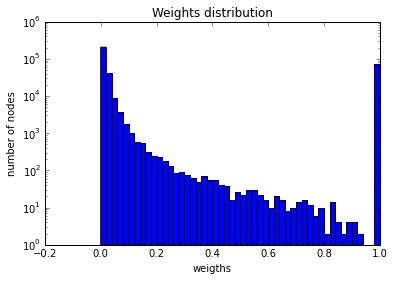

Normalized weights
mean: 0.225939038557
std: 0.402689499194
min: -9.80560312237e-15
max: 1.0
Original weights
mean: 156.073158632
std: 278.168051385
min: -6.77347067322e-12
max: 690.775527898


In [75]:
weight_distr(tbj)

At the <b>unfiltered, but projected networks weight ditributions</b>, one can see that most of them has almost a power-law distribution but there are many very strong weights which are coming from the well-clustered structure of the original data. The Average clustering was  0.774, and the number of nodes in fully connected neighborhood was 2346, and the number of bridges was  72. 

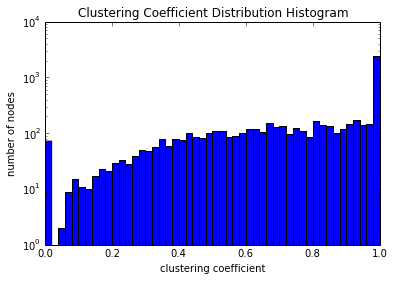

In [77]:
Image(filename='clustering_original.png') 

Most of the projections makes <b>even more important that small-world effect with many high weights</b>, only the Simple and the Newman method do not have a long-tail weight distribution. The Newman Projection's weight distribution is overall the most similar to the simple projection's weight distribution.
Hypergeometric Weighting makes the the most strong weights while keeping the power-law type of weight distribution.

<h3> 4. Disparity filter with Bonferroni Correction </h3> [6] [7]

<p><b>Disparity filter</b> is a network reduction algorithm to <b>extract the backbone structure of undirected weighted network </b>[8]. The advantage of the filtering method is that it does not destroy the multi-scale nature of the network (like the power-law weiht distributions above). The algorithm is developed by M. Angeles Serrano, Marian Boguna and Alessandro Vespignani. Basicaly it gives back the backbone structure of the filterable network that is why it is also called the backbone filtering </p>

<p> <b>The Bonferroni Correction</b> helps to avoid Type Error I. If we are testing <i>m</i> hypotheses, then one way of maintaining the familywise error rate (FWER) is to test each individual hypothesis at a statistical significance level of <i>1/m times</i> the desired maximum overall level. <b>Therefore in my Backbone test alpha is equal to 0,01/2L</b>, where L is the number of links. </p>

<b> Writing out files for the Backbone test, then run it </b> [9]

In [91]:
with open('simple.csv','wb') as csvfile:
    writer=csv.writer(csvfile)
    for ke,ve in simple.iteritems():
        for k,v in simple[ke].iteritems():
            writer.writerow((int(ke), int(k), int(v)))

In [24]:
with open('newman.csv','wb') as csvfile:
    writer=csv.writer(csvfile)
    for ke,ve in newman.iteritems():
        for k,v in newman[ke].iteritems():
            writer.writerow((ke, k, v))

In [25]:
with open('pearson.csv','wb') as csvfile:
    writer=csv.writer(csvfile)
    for ke,ve in pearson.iteritems():
        for k,v in pearson[ke].iteritems():
            writer.writerow((ke, k, v))

In [26]:
with open('cosine.csv','wb') as csvfile:
    writer=csv.writer(csvfile)
    for ke,ve in cosine.iteritems():
        for k,v in cosine[ke].iteritems():
            writer.writerow((ke, k, v))

In [27]:
with open('tbj.csv','wb') as csvfile:
    writer=csv.writer(csvfile)
    for ke,ve in tbj.iteritems():
        for k,v in tbj[ke].iteritems():
            writer.writerow((ke, k, v))

In [28]:
with open('jaccard.csv','wb') as csvfile:
    writer=csv.writer(csvfile)
    for ke,ve in jaccard.iteritems():
        for k,v in jaccard[ke].iteritems():
            writer.writerow((ke, k, v))

In [29]:
def extract_backbone(network, alpha, directed):
    nodes = set()
    edges = set()
    for n in network:
        k_n = len(network[n])
        if k_n > 1:
            sum_w = sum(network[n][nj] for nj in network[n])
            for nj in network[n]:
                pij = 1.0 * network[n][nj] / sum_w
                if (1 - pij) ** (k_n - 1) < alpha:
                    nodes.add(n)
                    nodes.add(nj)
                    if directed:
                        edges.add((n, nj, network[n][nj]))
                    else:
                        if n < nj:
                            edges.add((n, nj, network[n][nj]))
                        else:
                            edges.add((nj, n, network[nj][n]))
    return edges


In [79]:
def backbone_test(projection, infile, outfile):

    f = open(infile, "r")
    network = defaultdict(lambda : defaultdict(float))
    for line in f:
        fields = line.strip().split(',')
        network[fields[0]][fields[1]] = float(fields[2])
        network[fields[1]][fields[0]] = float(fields[2])
    f.close()
    
    directed = ("n")
    edgesc=[]
    
    for ke,ve in simple.iteritems():
            for k,v in simple[ke].iteritems():
                edgesc.extend((ke,k))
    alpha=float(0.01)/(2*len(edgesc))
    #float(0.01/2*len(edgesc))
    
    edges=extract_backbone(network, alpha, directed)
    
    with open(outfile, 'wb') as csvfile:
        writer=csv.writer(csvfile)
        for (fr,to,weight) in edges:
            writer.writerow((fr,to,weight))

    
    G = nx.read_weighted_edgelist(outfile, delimiter=',')
    print "Number of nodes:"+str(G.number_of_nodes())
    print "Number of edges:"+str(G.number_of_edges())
    print 'Network Desity: '+str(nx.density(G))
    giant = max(nx.connected_component_subgraphs(G), key=len)
    print 'Percentage of the number of nodes belonging to the giant component: '+str(float(giant.number_of_nodes())/float(G.number_of_nodes()))

    d = nx.degree(G)
    plt.hist(d.values(),bins=50)
    plt.title("Degree Distribution Histogram")
    plt.ylabel("number of nodes")
    plt.xlabel("degree")
    plt.yscale('log', nonposy='clip')
    plt.show()

    weights=[]
    for (_,_,k) in edges:
        weights.append(k)
    print "min:"+str(min(weights))
    print "max:"+str(max(weights))
    print "SD:"+str(np.std(weights))
    

    #plt.hist((weights),bins=1)
    #plt.title("Weights distribution")
    #plt.ylabel("number of nodes")
    #plt.xlabel("weigths")
    #plt.yscale('log', nonposy='clip')
    #plt.show() 

<h3> 4. Backbone Test -Final Results </h3>

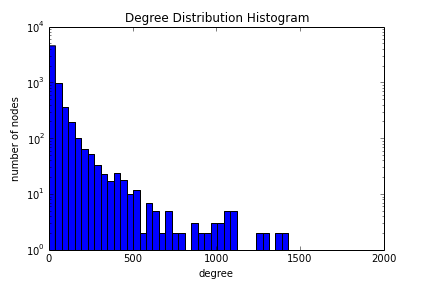

In [87]:
Image(filename='original.png') 

Original Degree Distribution without filtering

Number of nodes:161
Number of edges:341
Network Desity: 0.0264751552795
Percentage of the number of nodes belonging to the giant component: 0.645962732919


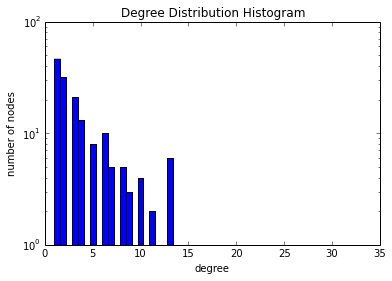

min:28.0
max:744.0
SD:117.649081703


In [92]:
backbone_test(simple, 'simple.csv', 'simple_backbone.csv')

The <b>Simple Projection</b> kept 161 nodes, mainly from the original giant component, the small not that important charachters disappeared. It is a good method when we only want to deal with the main hubs.

Number of nodes:316
Number of edges:353
Network Desity: 0.00709262607997
Percentage of the number of nodes belonging to the giant component: 0.101265822785


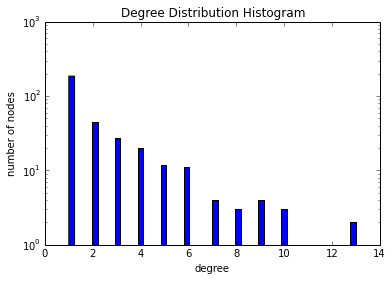

min:0.106796116505
max:1.0
SD:0.275732185559


In [82]:
backbone_test(jaccard, 'jaccard.csv', 'jaccard_backbone.csv')

The <b>Jaccard Similiarity </b> based method keeps more nodes and edges then the Simple Projection with a similar density as the original network (0,007).

Number of nodes:12
Number of edges:10
Network Desity: 0.151515151515
Percentage of the number of nodes belonging to the giant component: 0.333333333333


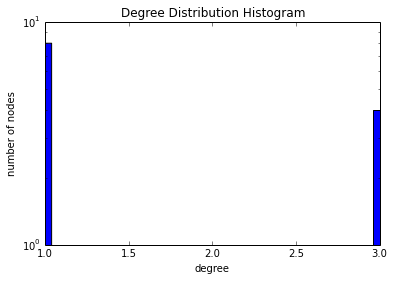

min:0.61173275417
max:0.938743597936
SD:0.0781873079363


In [83]:
backbone_test(cosine, 'cosine.csv', 'cosine_backbone.csv')

As it was written in the literature the <b>Cosine method</b> is good when the expected outcome is 0 or 1, here it was not the case so it did not perform well.

Number of nodes:51
Number of edges:39
Network Desity: 0.0305882352941
Percentage of the number of nodes belonging to the giant component: 0.137254901961


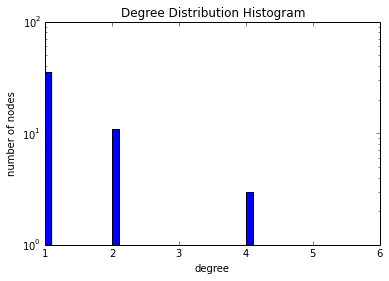

min:0.0227864995161
max:1.0
SD:0.204784183781


In [84]:
backbone_test(pearson, 'pearson.csv', 'pearson_backbone.csv')

The <b>Pearson Coefficient</b> was not the best choice either, it kept the soconf least number of nodes and edges, basically useless.

Number of nodes:357
Number of edges:620
Network Desity: 0.00975671167343
Percentage of the number of nodes belonging to the giant component: 0.669467787115


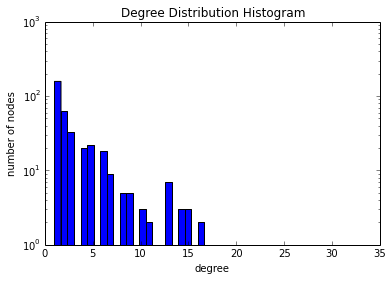

min:1.0
max:102.718476372
SD:14.0151868549


In [85]:
backbone_test(newman, 'newman.csv', 'newman_backbone.csv')

The <b>Newman Projection </b>gives nice results, it performs pretty well regarding the density and the size of the giant component, and kept almost the same amount of nodes like the Jaccard one but two times more edges.

Number of nodes:1425
Number of edges:1355
Network Desity: 0.00133550167554
Percentage of the number of nodes belonging to the giant component: 0.345263157895


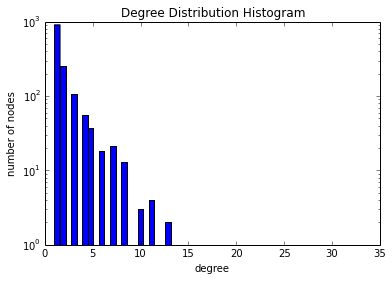

min:690.775527898
max:690.775527898
SD:2.27373675443e-13


In [86]:
backbone_test(tbj, 'tbj.csv', 'tbj_backbone.csv')

The <b>Hypergeometric Weighting</b> kept the most nodes and edges with a quite good density and a nice almost power-law degree distribution. 

<h3>5. Summary</h3>

<p></p>

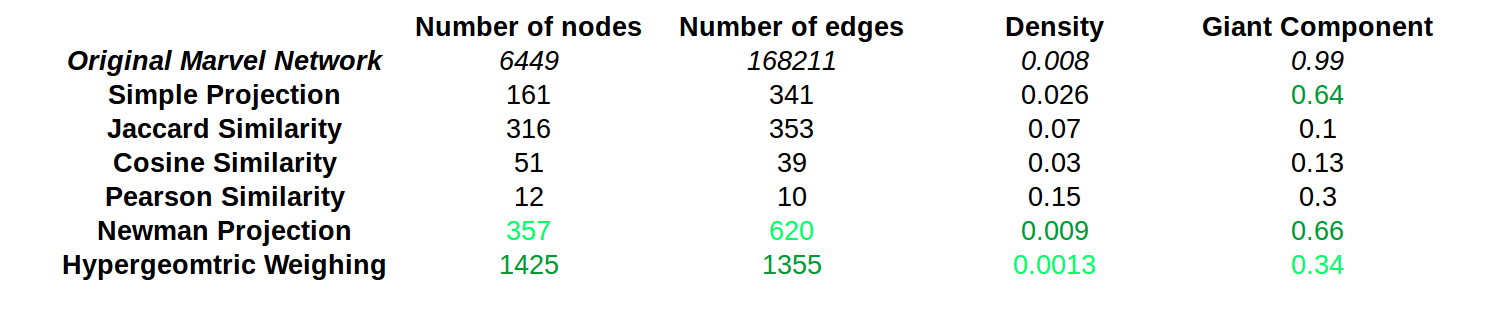

In [89]:
Image(filename='table.png') 

<p> Disparity filtering with the Bonferron correction is a very radical method, it keeps only the very important edges within the network. Comparing the final degree distributions with the original network it can be seen that <b>far more the Hypergeometric Weighting kept the most nodes and edges</b>, even though it is quite fragmented comapred to the Newman Projection. </p>
<p> The <b>Newman Projection captured in overall the best the structure of the original network</b>, while keeping the second highest amount of nodes and edges and having almost the same density. The Simple Projection ad Jaccard Similarity gave very similar results, and as it was expected the Cosine and Pearson similarity based projections did not perform well. </p>
<p> As the above described example shows with different projection methods we can get extremely different results therefore finding the most adequate method is crucial in any research. Here I tried to comapre 5 different methods with the same dataset and I found the Newman Projection captured the original network's structure the most, but the Hypergeometric weighting kept the most nodes and edges. </p>


<h3> 6. References </h3>

* [1] https://en.wikipedia.org/wiki/Bipartite_network_projection 
* [2] https://en.wikipedia.org/wiki/Jaccard_index
* [3] https://en.wikipedia.org/wiki/Cosine_similarity
* [4] https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient
* [5] Newman, M. E. J., 2001. Scientific collaboration networks. II. Shortest paths, weighted networks, and centrality. Physical Review E 64, 016132. 
* [6] Serrano, M.Angeles; Boguna, Marian; Vespignani, Alessandro (2009), "Extracting the multiscale backbone of complex weighted networks", Proceedings of the National Academy of Sciences 106 (16): 6483–6488, arXiv:0904.2389, Bibcode:2009PNAS..106.6483S, doi:10.1073/pnas.0808904106
* [7] https://en.wikipedia.org/wiki/Bonferroni_correction
* [8] https://en.wikipedia.org/wiki/Disparity_filter_algorithm_of_weighted_network
* [9] http://www.michelecoscia.com/?page_id=287
